### Setup

In [1]:
import os, sys
# HOME = os.environ['HOME']  # change if necessary
HOME = '/workspace/'
sys.path.append(f'{HOME}/wilson/Finite-groups/src')

In [2]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
%load_ext autoreload
%autoreload 2

In [3]:
t.set_grad_enabled(False)
device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [4]:
MODEL_DIR = '2024-12-20_19-12-16_S4_A4x2_MLP2_32_ubias_wd2e-5_BIG'
disable_progress_bars()
local_dir = f'{HOME}/models/{MODEL_DIR}'
if not os.path.exists(local_dir):
    snapshot_download(repo_id=f'wiwu2390/{MODEL_DIR}', local_dir=local_dir)
init_models, _= load_models(local_dir, sel=0)
final_models, params = load_models(local_dir, sel='final')
init_models = init_models[0].to(device)
final_models = final_models[0].to(device)
data = GroupData(params)

/workspace//wilson/Finite-groups/src/model_utils.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


Intersection size: 336/576 (0.58)
Added 336 elements from intersection
Added 0 elements from group 0: S(4)
Added 0 elements from group 1: times(A(4), Z(2))
Train set size: 336/576 (0.58)


In [5]:
loss_dict = test_loss(final_models.to(device), data)
g0_grokked = (loss_dict['G0_acc'] > 0.999)
g1_grokked = (loss_dict['G1_acc'] > 0.999)
print('G0 grokked', g0_grokked.sum())
print('G1 grokked', g1_grokked.sum())
grokked_idx = (g0_grokked | g1_grokked).nonzero().flatten()
labels = g0_grokked[grokked_idx] 
grokked_init_models = init_models[grokked_idx]
len(grokked_idx)

G0 grokked tensor(603, device='cuda:0')
G1 grokked tensor(43, device='cuda:0')


646

In [6]:
grokked_params = []
for inst in range(len(grokked_init_models)):
    init_params = t.concatenate([p.data.flatten() for p in grokked_init_models[inst].parameters()], dim=0)
    grokked_params.append(init_params)
grokked_params = t.stack(grokked_params, dim=0)
grokked_params.shape

torch.Size([646, 4376])

In [7]:
N = init_models.N
test_inputs = t.tensor(list(product(range(N), repeat=2)), device=device)
grokked_outputs = grokked_init_models(test_inputs)
grokked_outputs = einops.rearrange(grokked_outputs, 'batch instance vocab -> instance (batch vocab)')
grokked_outputs.shape

torch.Size([646, 13824])

In [28]:
all_outputs = final_models(test_inputs)
all_outputs_snap = F.one_hot(all_outputs.argmax(dim=-1), num_classes=all_outputs.shape[-1]).float()
all_outputs = einops.rearrange(all_outputs, 'batch instance vocab -> instance (batch vocab)')
all_outputs_snap = einops.rearrange(all_outputs_snap, 'batch instance vocab -> instance (batch vocab)')
all_outputs.shape

torch.Size([10000, 13824])

### t-SNE final output logits

In [30]:
# U, S, Vh = t.linalg.svd(all_outputs)
U, S, Vh = t.linalg.svd(all_outputs_snap)

In [31]:
S[0]**2 / (S**2).sum()

tensor(0.6268, device='cuda:0')

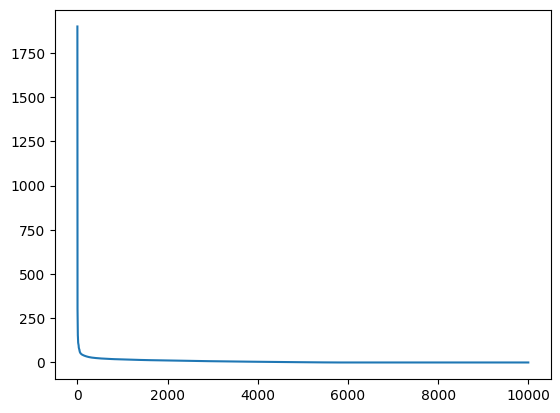

In [32]:
plt.plot(S.cpu().numpy())
plt.show()

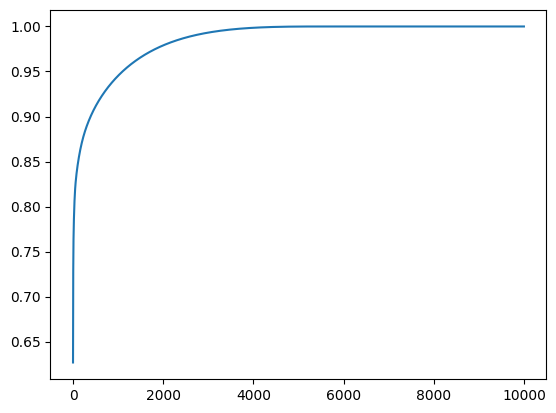

In [33]:
plt.plot(((S**2).cumsum(dim=0) / (S**2).sum()).cpu().numpy())
plt.show()

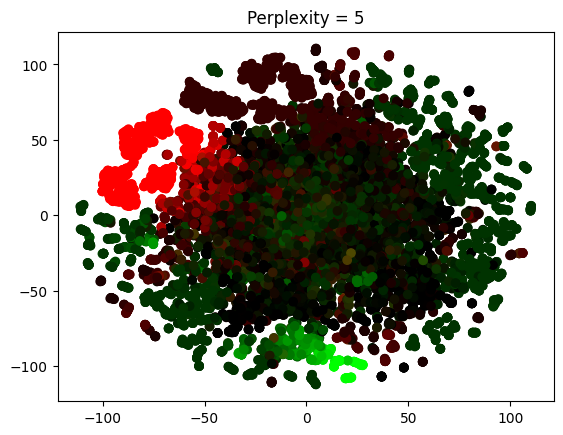

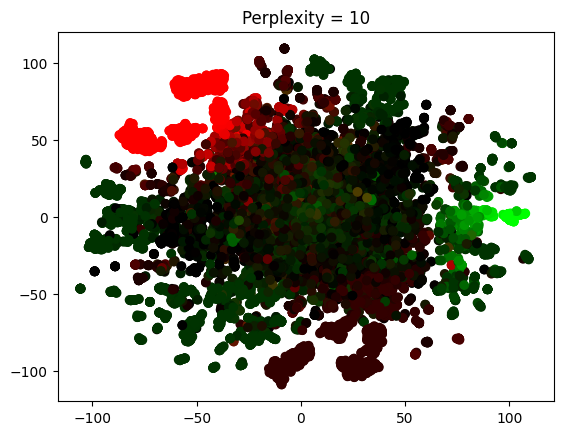

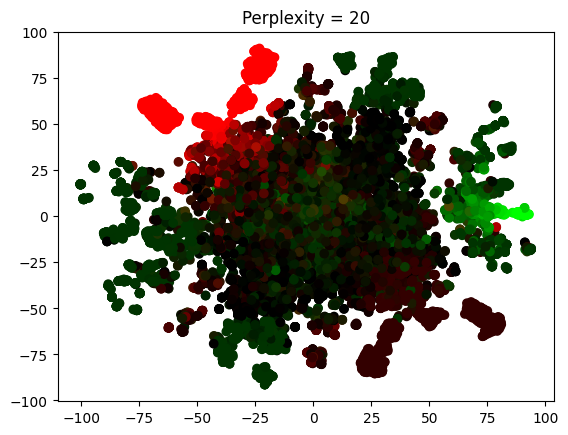

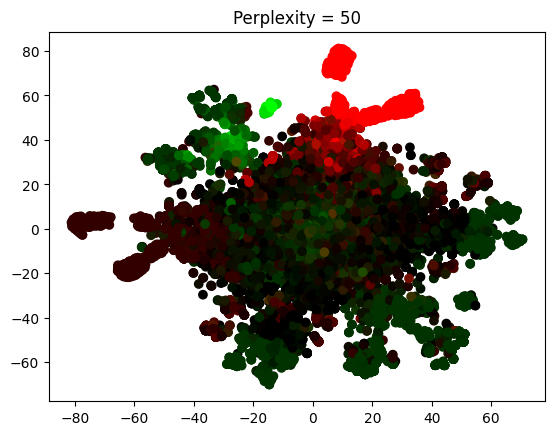

In [34]:
from sklearn.manifold import TSNE
U_reduced= U[:,:50]

intersect_size = len(data.train_data) / N**2
c = np.array([
    [(g0_acc.cpu() - intersect_size) / (1 - intersect_size), (g1_acc.cpu() - intersect_size) / (1 - intersect_size), 0]
    for g0_acc, g1_acc in zip(loss_dict['G0_acc'], loss_dict['G1_acc'])
])
c = np.clip(c, 0, 1)

for perplexity in [5, 10, 20, 50]:
    U_embed = TSNE(n_components=2, perplexity=perplexity).fit_transform(U_reduced.cpu().numpy())
    plt.scatter(U_embed[:,0], U_embed[:,1], c=c)
    plt.title(f'Perplexity = {perplexity}')
    plt.show()

In [108]:
logits = einops.rearrange(all_outputs, 'instance (batch vocab)-> batch instance vocab', batch=N**2, vocab=N)
instances = logits.shape[1]
g0_labels_repeat = einops.repeat(g0_labels, "batch -> batch n", n=instances)
g1_labels_repeat = einops.repeat(g1_labels, "batch -> batch n", n=instances)
union_acc = ((logits.argmax(-1) == g0_labels_repeat) | (logits.argmax(-1) == g0_labels_repeat)).sum(dim=0) / logits.shape[0]

(array([5195., 1200.,  786.,  437.,  973.,  183.,  186.,   63.,   64.,
          44.,   37.,   24.,   33.,   20.,   44.,   22.,   28.,   19.,
          12.,  630.]),
 array([0.58333331, 0.60416663, 0.625     , 0.64583331, 0.66666663,
        0.6875    , 0.70833331, 0.72916663, 0.75      , 0.77083331,
        0.79166663, 0.8125    , 0.83333331, 0.85416663, 0.875     ,
        0.89583331, 0.91666663, 0.9375    , 0.95833331, 0.97916663,
        1.        ]),
 <BarContainer object of 20 artists>)

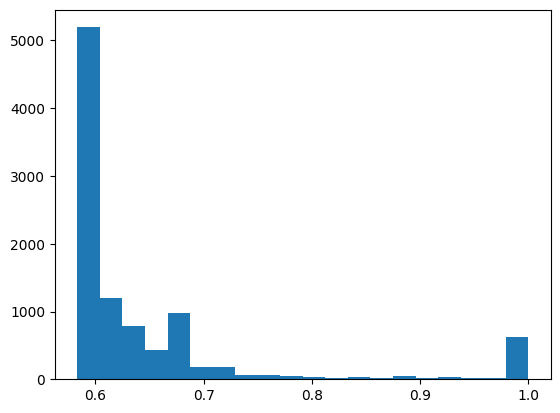

In [110]:
plt.hist(union_acc.cpu().numpy(), bins=20)

In [112]:
(union_acc > 0.999).sum()

tensor(603)